# DDPM Coursework Part 2 - Ben Hallett


## Problem 1 - Exploritory Data analysis

## 1.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.integrate as spi
from typing import Tuple, List, Callable
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import BatchNorm1d
from torch.nn.init import xavier_normal_, kaiming_normal_

In [3]:
# global experiment parameters
SAMPLE_RATE = 100 # Hz

In [4]:
# loading data
data_dict = dict(np.load(r'data\\coursework-2024+25-part2.npz'))
data_all = [it[1] for it in data_dict.items()]


In [5]:
print(data_dict.keys())
print(data_dict['x'].shape)
print(data_dict['u'].shape)


dict_keys(['x', 'u'])
(108, 2000)
(108, 2000)


Plotting timeseries data 

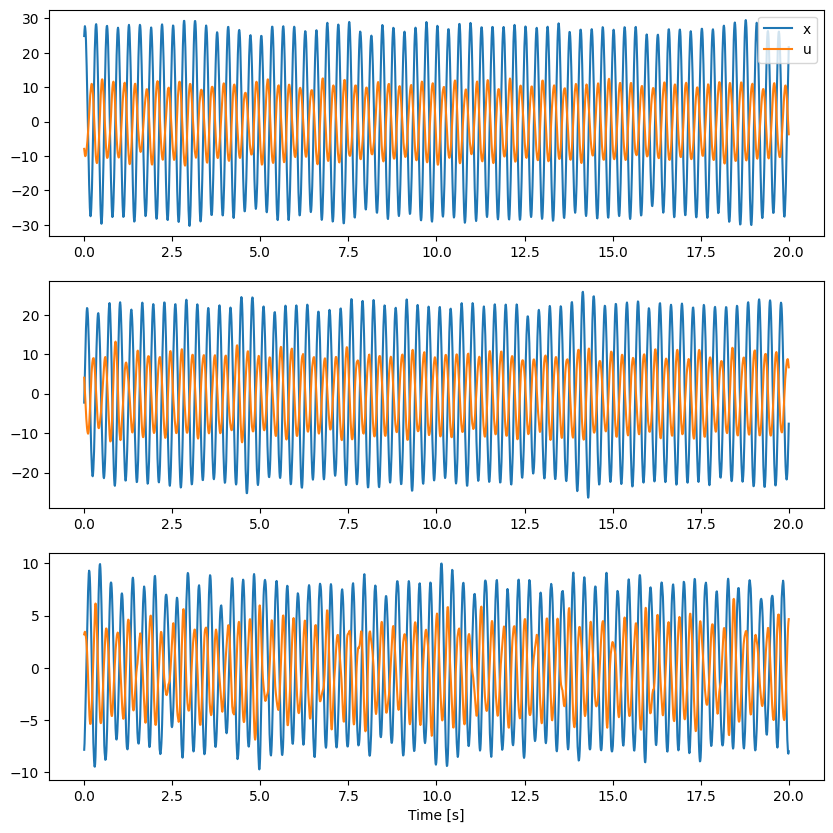

In [6]:
inds = np.random.choice(data_dict['x'].shape[0], 3, replace=False)

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
t = np.linspace(0, data_dict['x'].shape[1] / SAMPLE_RATE, data_dict['x'].shape[1])
for i, ind in enumerate(inds):
    axs[i].plot(t, data_dict['x'][ind], label='x')
    axs[i].plot(t, data_dict['u'][ind], label='u')
    
axs[0].legend()
axs[2].set_xlabel('Time [s]')
plt.show()
    


## 1.2
calculating standard deviation of each timeseries and plotting std(x) against std(u)

Text(0, 0.5, 'std(u)')

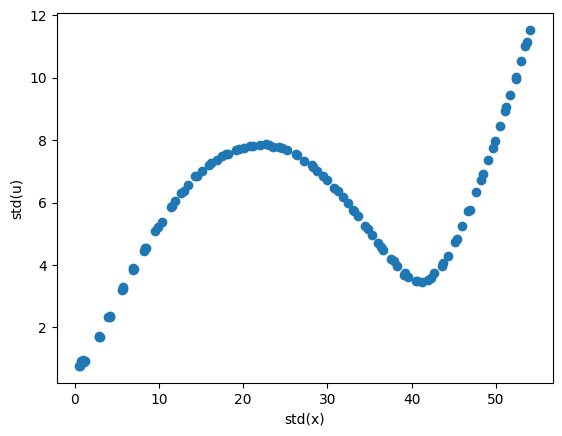

In [7]:
X = data_dict['x']
U = data_dict['u']

X_std = np.std(X, axis=1)
U_std = np.std(U, axis=1)

plt.plot(X_std, U_std, 'o')
plt.xlabel('std(x)')
plt.ylabel('std(u)')

We see that there appears to be a cubic function mapping std(x) to std(u) but there is no function mapping std(u) to std(x). So the force amplitude can be determined from the displacement amplitude, but not vice versa. Additionally we see that, perhaps somewhat unexpectedly the force amplitude actually decreases past a certain displacement amplitude, before increasing again. All of this implies that we cannot learn a function that takes input u and predicts the state x. This motivates a timeseries approach, where we use the previous displacement and force inputs to predict the next displacement.

## 1.3
Truncating each time series to the first 200 measurements

In [8]:
X = X[:, :200]
U = U[:, :200]

print(X.shape, U.shape)

(108, 200) (108, 200)


## 1.4
To normalise so that each timeseries has a maximum amplitude of one we can do the following 

In [9]:
X_max = np.max(X.flatten())
U_max = np.max(U.flatten())

X = X / X_max
U = U / U_max

assert np.max(X.flatten()) == 1
assert np.max(U.flatten()) == 1

print(X.shape, U.shape)

(108, 200) (108, 200)


## Problem 2 - Echo State Networks

## 2.1

In [16]:
def train_test_split(train_ratio, size, val_ratio=0):
    """
    splits the full dataset into training and test sets

    args:
    ------
    train_ratio : float
        The ratio of the dataset to use for training
    size : int
        The size of the dataset
    val_ratio : float, optional (default is 0)
        The ratio of the dataset to use for validation

    returns:
    --------
    train_inds : ndarray
        The indices of the training set
    test_inds : ndarray
        The indices of the test set
    val_inds : ndarray
        The indices of the validation set (if val_ratio > 0)
    """
    # again let's do a 60-40 split, this time splitting by trial
    split_pos = round(train_ratio*size)
    random_inds = np.random.permutation(size)
    train_inds = random_inds[:split_pos]
    test_inds = random_inds[split_pos:]

    if val_ratio > 0:
        val_pos = round(val_ratio*size)
        val_inds = test_inds[:val_pos]
        test_inds = test_inds[val_pos:]

        return train_inds, test_inds, val_inds
    
    return train_inds, test_inds

In [ ]:
sample_inds = []
for i in range(X.shape[0]):
    sample_std = np.std(X[i, :]*X_max)
    if sample_std >= 42:
        print(f'Found sample with std >= 42: {i}')
        sample_inds.append(i)

X_samples = X[sample_inds, :]
U_samples = U[sample_inds, :]


sample_inputs = np.stack([X_samples, U_samples], axis=-1)
print("sample inputs shape:")
print(sample_inputs.shape)

# taking a 60-40 train-test split
train_inds, test_inds = train_test_split(0.6, sample_inputs.shape[0])

X_train = sample_inputs[train_inds, 1:, 0]
U_train = sample_inputs[train_inds, :-1, :]
X_test = sample_inputs[test_inds, 1:, 0]
U_test = sample_inputs[test_inds, :-1, :]

print("train and test data shapes:")
print(X_train.shape, U_train.shape, X_test.shape, U_test.shape)

Found sample with std >= 42: 27
Found sample with std >= 42: 28
Found sample with std >= 42: 29
Found sample with std >= 42: 30
Found sample with std >= 42: 31
Found sample with std >= 42: 32
Found sample with std >= 42: 33
Found sample with std >= 42: 34
Found sample with std >= 42: 35
Found sample with std >= 42: 64
Found sample with std >= 42: 65
Found sample with std >= 42: 66
Found sample with std >= 42: 67
Found sample with std >= 42: 68
Found sample with std >= 42: 69
Found sample with std >= 42: 70
Found sample with std >= 42: 71
Found sample with std >= 42: 99
Found sample with std >= 42: 100
Found sample with std >= 42: 101
Found sample with std >= 42: 102
Found sample with std >= 42: 103
Found sample with std >= 42: 104
Found sample with std >= 42: 105
Found sample with std >= 42: 106
Found sample with std >= 42: 107
(26, 200, 2)
(16, 199) (16, 199, 2) (10, 199) (10, 199, 2)


## 2.2

ESN Code from workshop

In [11]:
def create_reservoir(size, in_size=1, spectral_radius=0.9):
    """
    Create a reservoir with the given size and spectral radius.

    Parameters
    ----------
    size : int
        The number of neurons in the reservoir.
    in_size : int, optional (default is 1)
        The number of input neurons.
    spectral_radius : float, optional (default is 0.9)
        The desired spectral radius of the reservoir weight matrix.

    Returns
    -------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    """
    # Create a random reservoir matrix with elements in [-0.5, 0.5]
    W = np.random.rand(size, size) - 0.5
    # Set diagonal elements to zero (no self feedback)
    np.fill_diagonal(W, 0)
    # Scale the matrix to have spectral radius = spectral_radius
    max_eig = np.max(np.abs(np.linalg.eigvals(W)))
    W *= spectral_radius / max_eig
    # Create a random input matrix with elements in [-0.5, 0.5]
    Win = np.random.rand(size, in_size) - 0.5
    return W, Win

def run_reservoir(W, Win, u, x = None):
    """
    Run the reservoir with the given input.

    Parameters
    ----------
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix.
    x : ndarray, optional
        The initial state vector of the reservoir. If not provided, it is set to zero.

    Returns
    -------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    """
    # Initialize the state vector if needed
    if x is None:
        x = np.zeros(W.shape[0])
    # Run the reservoir and store the state vectors
    all_x = np.zeros((u.shape[0], W.shape[0]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        all_x[i, :] = x
    return all_x

def train_reservoir(all_x, y):
    """
    Train the output weights of the reservoir.

    Parameters
    ----------
    all_x : ndarray
        The state vectors of the reservoir at each time step.
    y : ndarray
        The target output signal matrix.

    Returns
    -------
    Wout : ndarray
        The output weight matrix.
    """
    # Solve for the output weights using least squares
    return np.linalg.lstsq(all_x, y, rcond=None)[0]

def predict_reservoir(Wout, W, Win, u):
    """
    Predict the output signal of the reservoir.

    Parameters
    ----------
    Wout : ndarray 
        The output weight matrix.
    W : ndarray
        The reservoir weight matrix.
    Win : ndarray
        The input weight matrix.
    u : ndarray
        The input signal matrix.

    Returns
    -------
    y : ndarray
        The predicted output signal matrix.
    """
    # Initialize the state vector
    x = np.zeros(W.shape[0])
    # Run the reservoir and predict the output
    y = np.zeros((u.shape[0], Wout.shape[1]))
    for i in range(u.shape[0]):
        # Evaluate the reservoir (hidden layer) at the current time step
        x = np.tanh(np.dot(W, x) + np.dot(Win, u[i, :]))
        y[i, :] = np.dot(Wout.T, x)
    return y

creating and training an initial ESN on the training data. Because we saw that the amplitude of u appears to be a function of x, it makes sense to use a single input x and train the network to predict x and u at the next timestep

In [12]:
def train_esn(size, spectral_radius, train_data, test_data):
    """
    Train and predict using an Echo State Network (ESN) with the given parameters.

    args:
    ------
    size : int
        The number of neurons in the reservoir.
    spectral_radius : float
        The desired spectral radius of the reservoir weight matrix
    train_data : ndarray
        The training data to use for training the ESN, with shape (n_features, n_samples)
    test_data : ndarray
        The test data to evaluate the trained ESN, with shape (n_features, n_samples)
    
    returns:
    --------
    W_in : ndarray
        The input weight matrix
    W : ndarray
        The reservoir weight matrix
    W_out : ndarray
        The output weight matrix
    """
    # creating the reservoir with input size 2, corresponding to x 
    W, W_in = create_reservoir(size=size, in_size=2, spectral_radius=spectral_radius)
    # running the reservoir with the training data to generate hidden layer states
    hidden = run_reservoir(W, W_in, train_data[:, :-1].T)
    # time shifted by 1 so that the network learns to predict the next state
    W_out = train_reservoir(hidden, train_data[:, 1:].T) 

    return W_in, W, W_out

In [13]:
# training the ESN
W_in, W, W_out = train_esn(100, 0.9, U_train, U_test)

# making training and test predictions
train_preds = predict_reservoir(W_out, W, W_in, U_train[:, :-1].T)
test_preds = predict_reservoir(W_out, W, W_in, U_test[:, :-1].T)

NameError: name 'U_train' is not defined

now let's generate training and testing predictions

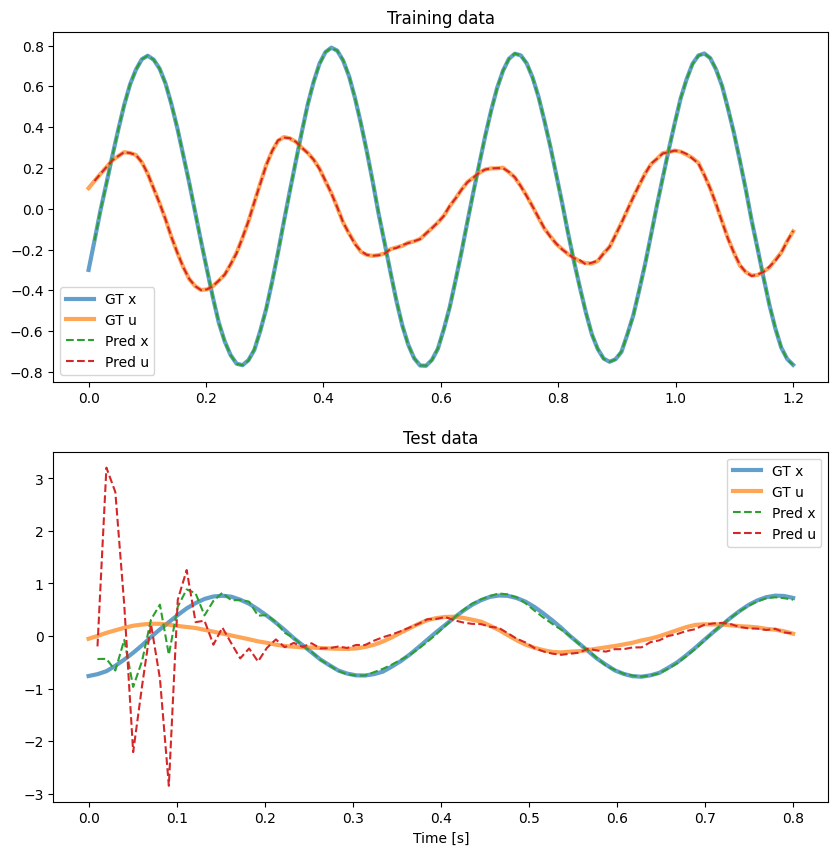

In [ ]:


fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, (data, preds) in enumerate(zip([U_train, U_test], [train_preds, test_preds])):
    t = np.linspace(0, data.shape[1]/SAMPLE_RATE, data.shape[1])
    axs[i].plot(t, data[0, :], label='GT x', linewidth=3, alpha=0.7)
    axs[i].plot(t, data[1, :], label='GT u', linewidth=3, alpha=0.7)
    axs[i].plot(t[1:], preds.T[0, :], label='Pred x', linestyle='--')
    axs[i].plot(t[1:], preds.T[1, :], label='Pred u', linestyle='--')
    axs[i].legend()

axs[1].set_xlabel('Time [s]')
axs[0].set_title('Training data')
axs[1].set_title('Test data')
plt.show()


We can see the warmup period introducing quite a lot of error initialy for the test data. No lets calculate the MSE

In [ ]:
def calc_mse(gt, pred):
    return np.mean((gt - pred)**2)

train_mse = calc_mse(U_train[:, 1:].T, train_preds)
test_mse = calc_mse(U_test[:, 1:].T, test_preds)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 2.8133249175290715e-06
Test MSE: 0.24447805645796958


## 2.3
Let's perform a grid search over the hyperparameters and select those which minimize the training loss. There are two hyperparameters, hidden_size and spectral radius.


In [ ]:
def esn_gridsearch(hidden_sizes:List, spectral_radius:List):
    # mse matrix to store the mse values for each combination of hidden size and spectral radius
    train_mse_mat = np.ones((len(hidden_sizes), len(spectral_radius)))*np.inf
    test_mse_mat = np.copy(train_mse_mat)

    for i, hs in tqdm(enumerate(hidden_sizes), desc="grid search progress"):
        for j, sr in enumerate(spectral_radius):
            W, W_in = create_reservoir(size=hs, in_size=2, spectral_radius=sr)
            hidden = run_reservoir(W, W_in, U_train[:, :-1].T)
            W_out = train_reservoir(hidden, U_train[:, 1:].T)
            train_preds = predict_reservoir(W_out, W, W_in, U_train[:, :-1].T)
            test_preds = predict_reservoir(W_out, W, W_in, U_test[:, :-1].T)
            # calculating mse
            train_mse = calc_mse(U_train[:, 1:].T, train_preds)
            test_mse = calc_mse(U_test[:, 1:].T, test_preds)
            train_mse_mat[i, j] = train_mse
            test_mse_mat[i, j] = test_mse

    opt_hs, opt_sr = np.unravel_index(np.argmin(train_mse_mat), train_mse_mat.shape)

    return train_mse_mat, test_mse_mat

let's perform the grid search and visualise the mse matrix

In [ ]:
def plot_mse_mat(ax, mse_mat, hs_list, sr_list, norm=LogNorm()):
    cax = ax.matshow(mse_mat, cmap='jet', norm=norm)
    # formatting 
    ax.set_xticks(np.arange(0, len(sr_list), 2))
    ax.set_xticklabels([f'{sr_list[k]:.2f}' for k in range(0, len(sr_list), 2)])
    ax.set_yticks(np.arange(len(hs_list)))
    ax.set_yticklabels([f'{hs}' for hs in hs_list])
    ax.set_xlabel('Spectral radius')
    ax.set_ylabel('Hidden size')

    return cax

grid search progress: 10it [00:03,  2.97it/s]


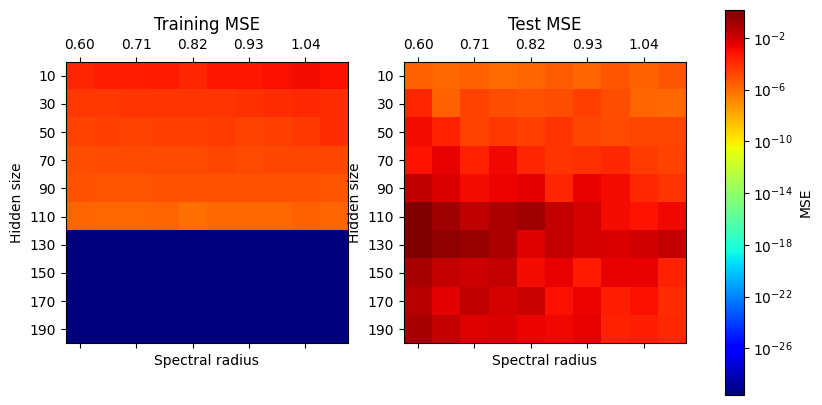

In [ ]:
hs_list = np.arange(10, 210, 20)
sr_list = np.linspace(0.6, 1.1, 10)

train_mse, test_mse = esn_gridsearch(hs_list, sr_list)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# combined norm so that a single colorbar can be used
combined = np.vstack([train_mse, test_mse]).flatten()
norm = LogNorm(vmin=np.min(combined), vmax=np.max(combined))

for i, mat in enumerate([train_mse, test_mse]):
    cax = plot_mse_mat(axs[i], mat, hs_list, sr_list, norm=norm)

fig.colorbar(cax, ax=axs, label='MSE')
axs[0].set_title('Training MSE')
axs[1].set_title('Test MSE')
plt.show()

We can see from comparing the train and test MSE grid search matrix that there is actually fairly poor correspondence between the train and test data performance for different hyperparameters. It seems that above a hidden size of 110, the model is completely over fit to the training data as it does poorly on the test data, but perfectly on the train data. If we were to select from the test data a small grid size is actually optimal. Let's constrict the grid size to smaller values and visualise one more test_mse, then select from the test_mse instead. We'd be more likely to find optimal hyperparameters with a training and testing set containing multiple timeseries, but this would be more expensive to compute. To make the grid_search less expensive we could use a random grid search instead of exhaustively searching each hyperparameter.

grid search progress: 9it [00:00, 66.77it/s]


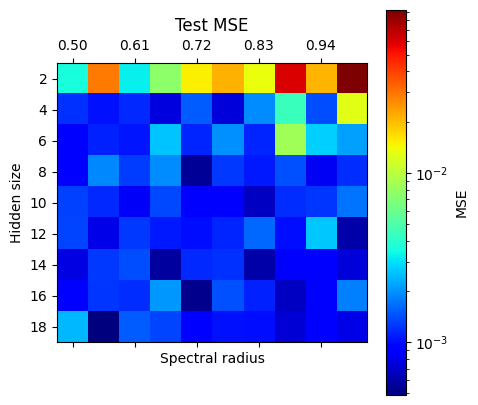

Best hidden size: 18
Best spectral radius: 0.5555555555555556


In [ ]:
hs_list = np.arange(2, 20, 2)
sr_list = np.linspace(0.5, 1, 10)
_, test_mse = esn_gridsearch(hs_list, sr_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = plot_mse_mat(ax, test_mse, hs_list, sr_list)
fig.colorbar(cax, ax=ax, label='MSE')
ax.set_title('Test MSE')
plt.show()

# best hyperparameters
best_hs, best_sr = np.unravel_index(np.argmin(test_mse), test_mse.shape)

print(f'Best hidden size: {hs_list[best_hs]}')
print(f'Best spectral radius: {sr_list[best_sr]}')

## 2.4
Now lets retrain on the entire dataset using the hyperparameters from the grid_search.

In [ ]:
train_inds, test_inds = train_test_split(0.6, X.shape[0])

U_train = np.vstack([X[train_inds, :].flatten(), U[train_inds, :].flatten()])
U_test = np.vstack([X[test_inds, :].flatten(), U[test_inds, :].flatten()])


print(U_train.shape, U_test.shape)

(2, 13000) (2, 8600)


In [ ]:
W_in, W, W_out = train_esn(best_hs, best_sr, U_train, U_test)

train_preds = predict_reservoir(W_out, W, W_in, U_train[:, :-1].T)
test_preds = predict_reservoir(W_out, W, W_in, U_test[:, :-1].T)

train_mse = calc_mse(U_train[:, 1:].T, train_preds)
test_mse = calc_mse(U_test[:, 1:].T, test_preds)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.003281591290982697
Test MSE: 0.0044869813146396365


we see after training on the whole dataset, that the training MSE is quite a bit worse, but noteably the testing accuracy is more than an order of magnitude better, suggesting that after the hyperparameter search the ESN is able to generalise well on the training data. In order to generalise this well, it is likely that the ESN network would have to learn the cubic relationship seen between displacement amplitude and force amplitude. We can test this hypothesis, by calculating the standard deviations of the model predictions and plotting this against that of the ground truth data.

(2, 21598)
107.99


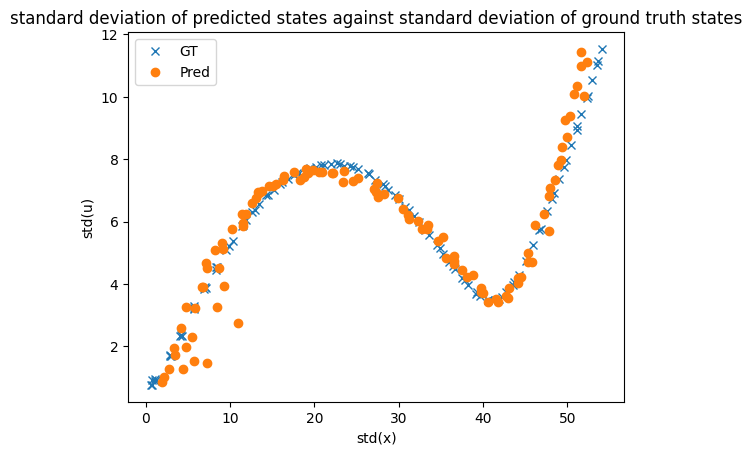

In [ ]:
all_preds = np.hstack([train_preds.T, test_preds.T])
print(all_preds.shape)
print(all_preds.shape[1] / 200)

all_preds[0, :] *= X_max
all_preds[1, :] *= U_max

X_pred_std = []
U_pred_std = []
for i in range(round(all_preds.shape[1]/200)):
    time_series = all_preds[:, i*200:(i+1)*200]
    X_pred_std.append(np.std(time_series[0, :]))
    U_pred_std.append(np.std(time_series[1, :]))

plt.plot(X_std, U_std, "x", label='GT')
plt.plot(X_pred_std, U_pred_std, 'o', label='Pred')
plt.xlabel('std(x)')
plt.ylabel('std(u)')
plt.title('standard deviation of predicted states against standard deviation of ground truth states')
plt.legend()
plt.show()

We can see from this recreation of the plot in question 1, that the ESN has learned a remarkably good fit to the data. This is quite astounding when you consider that the model is achieving this by learning a single fully connected layer between the random hidden activations of the ESN and the output. Clearly the random reccurent dynamics of the ESN are able to capture this cubic relationship in a manner that can be extracted by a linear fit.

## Problem 3 - RNNs

## 3.1
Since we are no training a deeper network, it makes sense to use a train-test-val split so that we can implement early stopping during training, to avoid overfitting.
We will keep the proportion of training data the same, so that we have a 60-20-20 train-test-val split.

In [ ]:
train_inds, test_inds, val_inds = train_test_split(0.59, X.shape[0], val_ratio=0.205) # tweaked a bit so that there are 2^6 samples in the training set

# splitting data into (batch, time, features)
U_train = torch.from_numpy(np.stack([X[train_inds, :], U[train_inds, :]], axis=-1))
U_test = torch.from_numpy(np.stack([X[test_inds, :], U[test_inds, :]], axis=-1))
val_data = torch.from_numpy(np.stack([X[val_inds, :], U[val_inds, :]], axis=-1))

# converting the data to float32 for training
U_train = U_train.float()
U_test = U_test.float()
val_data = val_data.float()

print(U_train.shape, U_test.shape, val_data.shape)

torch.Size([64, 200, 2]) torch.Size([22, 200, 2]) torch.Size([22, 200, 2])


## 3.2 and 3.3

We can use the Pytorch implementation of a vanilla RNN and create a RNN_Net class as a wrapper, which implements a fully connected output layer, to make predictions from the hidden layer activations.

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNN_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=1, nonlinearity='relu', bias=True, device=DEVICE)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, return_hidden=False):
        out, hidden = self.rnn(x)
        out = self.fc(out)
        
        if return_hidden:
            return out, hidden
        return out


Training Script

In [ ]:

def train_rnn(net: nn.Module, train_data: torch.Tensor, val_data: torch.Tensor, batch_size=32, 
              num_epochs: int = 100, learning_rate: float = 0.01, betas: Tuple = (0.9, 0.999), clip_thresh: float = 1):
    """
    Trains RNN based net model for num_epochs epochs, using BPTT with cross entropy loss and Adam optimizer. 
    The learning rate is decayed exponentially using a scheduler so that the final learning rate is 1% of the
    initial learning rate.

    args:
    -----
    net: nn.Module - RNN network to train
    train_data: ndarray - training data with shape (batch_size, seq_len, input_size)
    val_data: ndarray - validation data with shape (batch_size, seq_len, input_size)
    
    optional:
    ---------
    num_epochs: int - number of epochs to train the model for. Default is 100
    learning_rate: float - learning rate for the Adam optimizer. Default is 0.001
    betas: Tuple - betas for the Adam optimizer. Default is (0.9, 0.999)
    clip_thresh: float - threshold for gradient clipping. Default is 1

    returns:
    --------
    net: nn.Module - best performing model instance
    training_log: dict - dictionary containing training and validation loss, learning rate and epoch number
    """
    
    # loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
    # using exponential learning rate scheduler for better stability once the loss is small.
    gamma = 0.01**(1/num_epochs) # setting gamma so that the final learning rate is 1% of the initial learning rate
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # training log
    training_log = {'train_loss': [],  
                    'val_loss': [],
                    'learning_rate': [],
                    'epoch': []}

    # determining the number of batches per epoch
    batches = train_data.shape[0] // batch_size
    if train_data.shape[0] % batch_size > 0:
        batches += 1

    best_model = None
    best_loss = np.inf
    
    # moving everything to the same device
    net = net.to(DEVICE)
    train_data = train_data.to(DEVICE)
    val_data = val_data.to(DEVICE)
    
    # training loop using BPTT
    for epoch in range(num_epochs):
        training_log['epoch'].append(epoch+1)
        # training phase
        net.train()    
        for batch in range(batches):
            optimizer.zero_grad() # zeroing gradients before each forward pass to avoid accumulation
            
            # getting the current batch from the training data
            train_batch = train_data[batch*batch_size:(batch+1)*batch_size, :, :]
            # skipping last sequence element for prediction
            output = net(train_batch[:, :-1, :]) # output shape should be (batch_size, seq_len, output_size)
            assert output.shape == train_batch[:, 1:, :].shape, f'output shape: {output.shape}, target shape: {train_batch[:, 1:, :].shape} mismatch'

            # calculating loss and backpropagating
            loss = criterion(output, train_batch[:, 1:, :]) # skipping first element to get target sequence
        
            loss.backward()
            # implementing gradient clipping before stepping the optimizer
            nn.utils.clip_grad_norm_(net.parameters(), clip_thresh)
            optimizer.step()
        
        # validation phase
        net.eval()
        with torch.no_grad():
            val_output_logits = net(val_data[:, :-1, :])
            val_loss = criterion(val_output_logits, val_data[:, 1:, :])
            
        # stepping the learning rate scheduler
        training_log['learning_rate'].append(scheduler.get_last_lr()[0])
        scheduler.step() # decaying the learning rate by gamma
        
        # logging training and validation loss at the end of each epoch
        training_log['train_loss'].append(loss.item())
        training_log['val_loss'].append(val_loss.item())
        
        # saving best model
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model = net.state_dict()

        if (epoch+1) % 10 == 0:
            print('--------------------------------')
            print(f'Epoch {epoch+1}, train Loss: {loss.item()}, val loss: {val_loss.item()}')
            print('--------------------------------\n')

    # once training is complete, we can load the best model, and return the training log
    net.load_state_dict(best_model)
    return net, training_log

training a vanilla RNN using the script above

In [ ]:
vanilla_rnn = RNN_Net(input_size=2, hidden_size=20, output_size=2)
vanilla_rnn, training_log = train_rnn(vanilla_rnn, U_train, val_data, num_epochs=200, learning_rate=0.01, batch_size=32)

--------------------------------
Epoch 10, train Loss: 0.012823246419429779, val loss: 0.019759057089686394
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.00439499132335186, val loss: 0.0059016067534685135
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.002205657074227929, val loss: 0.002593027427792549
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.0013297242112457752, val loss: 0.0016146512934938073
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.0010531580774113536, val loss: 0.0012263067765161395
--------------------------------

--------------------------------
Epoch 60, train Loss: 0.000899414299055934, val loss: 0.0010033253347501159
--------------------------------

--------------------------------
Epoch 70, train Loss: 0.0008063496206887066, val loss: 0.0008789777639321983
--------------------------------


plotting the results

In [ ]:
def visualise_training_log(training_log):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(training_log['epoch'], training_log['train_loss'], label='Training loss')
    ax.plot(training_log['epoch'], training_log['val_loss'], label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title('Training and validation curves')
    plt.show()

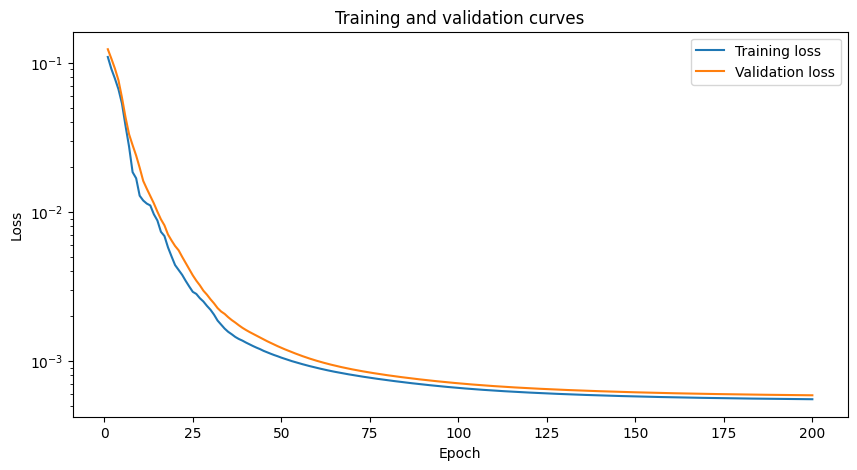

Test loss: 0.0006211533327586949


In [ ]:
visualise_training_log(training_log)

# getting the testing loss
test_data = U_test.to(DEVICE)
vanilla_rnn.eval()
with torch.no_grad():
    test_output = vanilla_rnn(test_data[:, :-1, :])
    test_loss = nn.MSELoss()(test_output, test_data[:, 1:, :])

print(f'Test loss: {test_loss.item()}')

We see good agreement between the training and validation loss throughout training, with some perhaps very slight overfitting as the loss gets very low. Additionally we see that the test loss evaluated on the held out test data is similar to the observed training and validation loss at epoch 200.

## 3.5
Let's implemented the light GRU architecture, for which the hidden layer activations are goverened by the following equations 
$$
\begin{align}
    &\bm{z}_t = \sigma\big(BN(W_{zx}\bm{x}_t) + U_z\bm{h}_{t-1}\big) 
    \\
    &\bm{\tilde{h}}_t = \mathrm{ReLU}\big( BN(W_{hx}\bm{x}_t) + U_{h}\bm{h}_{t-1} \big)
    \\
    &\bm{h}_t = \bm{z}_t \odot \bm{h}_{t-1} + (1 - \bm{z}_t)\odot \bm{\tilde{h}}_t
\end{align}
$$

where $\bm{z}_t$ is the gating vector, which controls how much of the old hidden layer information is remembered at each timestep. $W$ terms denote feedforward connections and $U$ terms denote reccurent connections. The $BN$ operator corresponds to the batch norm operation which is given by

$$
BN(a) = \gamma \odot \frac{a - \mu_b}{\sqrt{\sigma_b^2 + \epsilon}} + \beta
$$

where $\mu_b$ and $\sigma_b^2$ are the minibatch mean and variance, respectively. The terms $\gamma$ and $\beta$ are learnable parameters and the term $\beta$ removes the need for a bias term in the hidden layer and gating vector equations. At evaluation time $\mu_b$ and $\sigma_b^2$ will be frozen based on the running average of their values during training.

In [ ]:
def get_stable_matrix(A):
    """
    Rescales the input matrix so that all eigenvalues <= 1
    """
    A = A / torch.max(torch.abs(torch.linalg.eigvals(A)))
    return A

class Light_GRU(nn.Module):
    """
    implementation of the light GRU model from the paper "A Light Gated Recurrent Unit for Language Modeling" by Roy et al. (2019)
    """ 
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # randomly initiallizing the feedforward weights using xavier and kaiming initializations for sigmoid and relu respectively
        self.Wzx = nn.Parameter(xavier_normal_(torch.empty(hidden_size, input_size), gain=1))
        self.Whx = nn.Parameter(kaiming_normal_(torch.empty(hidden_size, input_size), mode='fan_in', nonlinearity='relu'))
        # initializing the recurrent weights, this time ensuring stability by rescaling each matrix according to its eigenvalues
        self.Uz = nn.Parameter(get_stable_matrix(xavier_normal_(torch.empty(hidden_size, hidden_size), gain=1)))
        self.Uh = nn.Parameter(get_stable_matrix(kaiming_normal_(torch.empty(hidden_size, hidden_size), mode='fan_in', nonlinearity='relu')))
        # learnable batch norms
        self.bn_z = BatchNorm1d(hidden_size)
        self.bn_h = BatchNorm1d(hidden_size)
        # defining nonlinearities
        self.gate_act = nn.Sigmoid()
        self.hidden_act = nn.ReLU()

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)
               
    def recurrent_step(self, input, hidden):
        """light-GRU timestep"""
        z_t = self.gate_act(self.bn_z(input @ self.Wzx.T) +  hidden @ self.Uz.T)
        h_ungated = self.hidden_act(self.bn_h(input @ self.Whx.T) + hidden @ self.Uh.T)
        h_t = z_t * hidden + (1 - z_t) * h_ungated
        return h_t

    def forward(self, input, hidden=None):
        """
        args:
        -----
        input: ndarray - input data with shape (seq_len, batch_size, input_size)
        
        hidden: ndarray - initial hidden state with shape (batch_size, hidden_size)
        """

        if hidden is None:
            hidden = self.init_hidden(input)
        
        timeseries = []
        steps = input.shape[0]
        for i in range(steps):
            hidden = self.recurrent_step(input[i], hidden)
            timeseries.append(hidden)
        
        timeseries = torch.stack(timeseries, dim=0)
        hidden_final = hidden
        
        return timeseries, hidden_final
    
class Light_GRU_Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_first=True):
        super().__init__()
        self.rnn = Light_GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_first = batch_first

    def forward(self, x, return_hidden=False):
        if self.batch_first:
            x = torch.permute(x, (1, 0, 2))
        
        out, hidden = self.rnn(x)
        out = self.fc(out)

        if self.batch_first:
            out = torch.permute(out, (1, 0, 2))
        
        if return_hidden:
            return out, hidden
        return out

initialising and training the light-GRU architecture, with the same number of hidden layers

In [ ]:
light_gru = Light_GRU_Net(input_size=2, hidden_size=40, output_size=2, batch_first=True)
light_gru, training_log = train_rnn(light_gru, U_train, val_data, num_epochs=50, learning_rate=0.01, batch_size=32)


--------------------------------
Epoch 10, train Loss: 0.014913542196154594, val loss: 0.017791975289583206
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.009686722420156002, val loss: 0.010996363125741482
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.008096433244645596, val loss: 0.008866935968399048
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.007705954369157553, val loss: 0.008355947211384773
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.007562506478279829, val loss: 0.00817498192191124
--------------------------------



TypeError: visualise_training_log() takes 1 positional argument but 3 were given

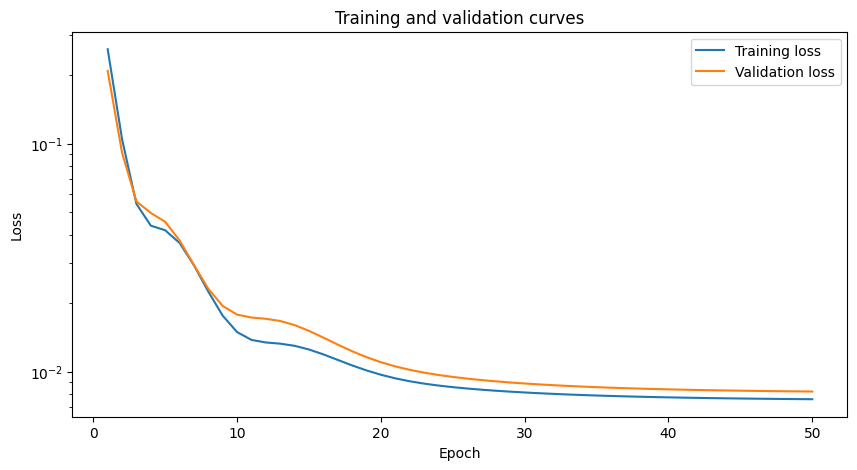

Test loss: 0.010775729082524776


In [ ]:
visualise_training_log(training_log)

light_gru.eval()
with torch.no_grad():
    test_output = light_gru(test_data[:, :-1, :])
    test_loss = nn.MSELoss()(test_output, test_data[:, 1:, :])

print(f'Test loss: {test_loss.item()}')

We actually see loss converge to a value about an order of magnitude higher than the vanilla RNN model. This could be as a consequence of not having tuned the hyperparameters optimally, or because the forget mechanic of the light-GRU actually harms performance.

## Problem 4 - Neural ODEs

## 4.1

Creating delay embedded train-val-test split

In [ ]:
train_inds, test_inds = train_test_split(0.59, X.shape[0])

# forming delay embeddings for the training and test data
U_train = torch.from_numpy(np.stack([X[train_inds, :], U[train_inds, :]], axis=-1))
U_test = torch.from_numpy(np.stack([X[test_inds, :], U[test_inds, :]], axis=-1))

X_train = U_train[:, 1:-1, 0].squeeze().float()
Y_train = U_train[:, 2:, 0].squeeze().float()
X_test = U_test[:, 1:-1, 0].squeeze().float()
Y_test = U_test[:, 2:, 0].squeeze().float()

# clipping so that there is correspondence between U, X and Y
U_train = U_train[:, :-2, :].float() # ensuring float 32
U_test = U_test[:, :-2, :].float()

print(U_train.shape, U_test.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([64, 198, 2]) torch.Size([44, 198, 2]) torch.Size([64, 198]) torch.Size([64, 198]) torch.Size([44, 198]) torch.Size([44, 198])


## 4.2

Based on the delay embeddings, we can formulate the ODE in the following manner.

$$
\frac{dx}{dt} = f(x_{t-1}, u_{t-1})
$$

where f is a black box DNN consisting of fully connected feedforward layers and $x_t$ is the current state of the neural ODE and $x_{t-1}$ and $u_{t-1}$ form the external input at time $t$. If $u_{t-1} = 0$, the system would be predicting the evolution of the state (displacement) without forcing.

In [ ]:
# from the lab notebook...

class Neural_ODE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers):
        super().__init__()
        # Define the feedforward neural network
        network = [nn.Linear(input_size, hidden_size), nn.ELU()]
        for _ in range(layers - 1): # Add hidden layers - as many as specified
            network.extend([nn.Linear(hidden_size, hidden_size), nn.ELU()])
        network.append(nn.Linear(hidden_size, output_size)) # final layer is not followed by an activation function so that the output is unbounded
        self.network = nn.Sequential(*network)
    
    def forward(self, x, input, steps, stepsize):
        """
        forward call using the euler method to approximate the ivp solution.

        args:
        -----
        x: ndarray - current state of the system with shape (batch_size, output_size)
        input: ndarray - input to the system with shape (batch_size, input_size)
        steps: int - number of steps to take
        stepsize: float - stepsize for the ODE solver

        returns:
        --------
        out: ndarray - output of the system at each time step with shape (batch_size, steps, output_size)
        """
        out = torch.zeros(x.shape[0], steps, x.shape[1]).to(x.device) # initial condition is not included
        
        # euler method
        for i in range(steps):
            rhs = self.network(input).squeeze() # to get rid of the last dimension if it is 1
            x = x + stepsize * rhs
            out[:, i, :] = x
        
        return out
    

## 4.3
Let's now train the neural ODE using single timestep predictions.

In [ ]:
def train_neural_ode(net: nn.Module, input_data: torch.Tensor, state_in: torch.Tensor, state_out: torch.Tensor, batch_size=32, 
                     num_epochs: int = 100, learning_rate: float = 0.01, betas: Tuple = (0.9, 0.999), clip_thresh: float = 1):
    """
    Trains RNN based net model for num_epochs epochs, using BPTT with cross entropy loss and Adam optimizer. 
    The learning rate is decayed exponentially using a scheduler so that the final learning rate is 1% of the
    initial learning rate.

    args:
    -----
    net: nn.Module - RNN network to train
    train_data: ndarray - training data with shape (batch_size, seq_len, input_size)
    val_data: ndarray - validation data with shape (batch_size, seq_len, input_size)
    
    optional:
    ---------
    num_epochs: int - number of epochs to train the model for. Default is 100
    learning_rate: float - learning rate for the Adam optimizer. Default is 0.001
    betas: Tuple - betas for the Adam optimizer. Default is (0.9, 0.999)
    clip_thresh: float - threshold for gradient clipping. Default is 1

    returns:
    --------
    net: nn.Module - best performing model instance
    training_log: dict - dictionary containing training and validation loss, learning rate and epoch number
    """
    
    # loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
    # using exponential learning rate scheduler for better stability once the loss is small.
    gamma = 0.01**(1/num_epochs) # setting gamma so that the final learning rate is 1% of the initial learning rate
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # training log
    training_log = {'train_loss': [],  
                    'learning_rate': [],
                    'epoch': []}

    # determining the number of batches per epoch
    batches = input_data.shape[0] // batch_size
    if input_data.shape[0] % batch_size > 0:
        batches += 1

    best_model = None
    best_loss = np.inf
    
    # moving everything to the same device
    net = net.to(DEVICE)
    input_data = input_data.to(DEVICE)
    state_in = state_in.to(DEVICE)
    state_out = state_out.to(DEVICE)
    net.train()

    # training loop using BPTT
    for epoch in range(num_epochs):
        training_log['epoch'].append(epoch+1)
        
        for batch in range(batches):
            optimizer.zero_grad() # zeroing gradients before each forward pass to avoid accumulation
            
            # getting the current batch from the training data
            input_batch = input_data[batch*batch_size:(batch+1)*batch_size, :, :]
            state_in_batch = state_in[batch*batch_size:(batch+1)*batch_size, :]
            state_out_batch = state_out[batch*batch_size:(batch+1)*batch_size, :]

            # producing a prediction of the state at the next timestep SHOULD BE IN A LOOP
            batch_output = net(state_in_batch, input_batch, steps=1, stepsize=1/SAMPLE_RATE)  
            batch_output = batch_output.squeeze() # removing the extra dimension
    
            # calculating loss and backpropagating
            loss = criterion(batch_output, state_out_batch) # comparing next state prediction to the actual next state
        
            loss.backward()
            # implementing gradient clipping before stepping the optimizer
            # nn.utils.clip_grad_norm_(net.parameters(), clip_thresh)
            optimizer.step()
        
        # stepping the learning rate scheduler
        training_log['learning_rate'].append(scheduler.get_last_lr()[0])
        scheduler.step() # decaying the learning rate by gamma
        
        # logging training and validation loss at the end of each epoch
        training_log['train_loss'].append(loss.item())
        
        # saving best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = net.state_dict()

        if (epoch+1) % 10 == 0:
            print('--------------------------------')
            print(f'Epoch {epoch+1}, train Loss: {loss.item()}')
            print('--------------------------------\n')

    # once training is complete, we can load the best model, and return the training log
    net.load_state_dict(best_model)
    net.eval()

    return net, training_log

In [ ]:
ode_net = Neural_ODE(input_size=2, hidden_size=20, output_size=1, layers=5)
ode_net, training_log = train_neural_ode(ode_net, U_train, X_train, Y_train, num_epochs=200, learning_rate=0.1, batch_size=32)

--------------------------------
Epoch 10, train Loss: 0.0046930983662605286
--------------------------------

--------------------------------
Epoch 20, train Loss: 0.003695456776767969
--------------------------------

--------------------------------
Epoch 30, train Loss: 0.0032486626878380775
--------------------------------

--------------------------------
Epoch 40, train Loss: 0.0029920553788542747
--------------------------------

--------------------------------
Epoch 50, train Loss: 0.002979913027957082
--------------------------------

--------------------------------
Epoch 60, train Loss: 0.002963346429169178
--------------------------------

--------------------------------
Epoch 70, train Loss: 0.0029558755923062563
--------------------------------

--------------------------------
Epoch 80, train Loss: 0.0029510746244341135
--------------------------------

--------------------------------
Epoch 90, train Loss: 0.0029476226773113012
--------------------------------

----

Visualising the training loss curve shows a plateau in the training after only 25 epochs

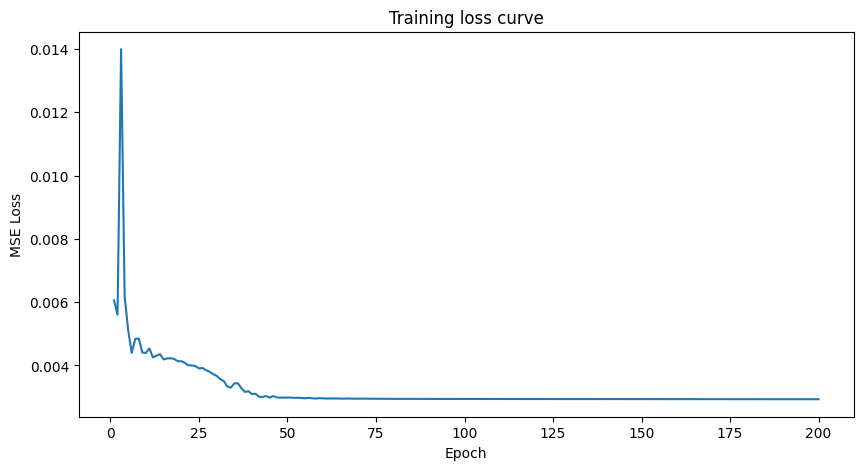

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(training_log['epoch'], training_log['train_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training loss curve')
plt.show()

## 4.4

Let's plot the prediction for a single test time series using the trained neural ODE

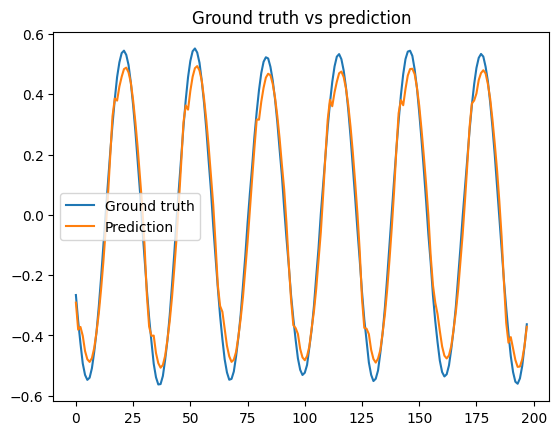

In [ ]:
randind = np.random.randint(0, U_test.shape[0])
U_rand = U_test[randind].unsqueeze(0).to(DEVICE)
X_rand = X_test[randind].unsqueeze(0).to(DEVICE)
Y_rand = Y_test[randind].unsqueeze(0)

Y_pred = ode_net(X_rand, U_rand, steps=1, stepsize=1/SAMPLE_RATE)

Y_pred = Y_pred.squeeze().detach().cpu().numpy()
Y_rand = Y_rand.squeeze().detach().cpu().numpy()


plt.plot(Y_rand, label='Ground truth')
plt.plot(Y_pred, label='Prediction')
plt.legend()
plt.title('Ground truth vs prediction')
plt.show()

Let's calculate error on the full test set

In [ ]:
# moving the test data to the correct device
X_test = X_test.to(DEVICE)
Y_test = Y_test.to(DEVICE)
U_test = U_test.to(DEVICE)

# getting test predictions
Y_pred = ode_net(X_test, U_test, steps=1, stepsize=1/SAMPLE_RATE)
Y_pred = Y_pred.squeeze()

critereon = nn.MSELoss()
test_loss = critereon(Y_pred, Y_test)

print(f'Test MSE loss: {test_loss.item()}')

Test MSE loss: 0.00301814591512084


So the test error is comparible to the train error which is good and similar to the test error of the vanilla RNN.

## 4.5

We've seen from the training that both networks perform similarly when tasked with predicting the next timestep. The advantage of using the neural ODE approach over an RNN is that the neural ODE model is not restricted to the sampling rate that it is trained on, since it learns the vector field of the dynamical system, that can be integrated to give the solution at any point. RNNs on the other hand, learn the solution of the dynamical system at fixed points in time, and are much more sensitive to nonlinearities in the solution.

Since this task involves predicting timeseries data generated by a physical system in continuous time, in principle the neural ODE approach makes more sense, as we could even potentially analyse the phase space to learn underlying behaviours of the system. That being said, given the absence of any obvious nonlinearities in the data, the RNN approach is perfectly adequate.

In fact, since we have a 2 dimensional input space, let's visualise the $dx/dt$ scalar field it produces.

(100, 100)


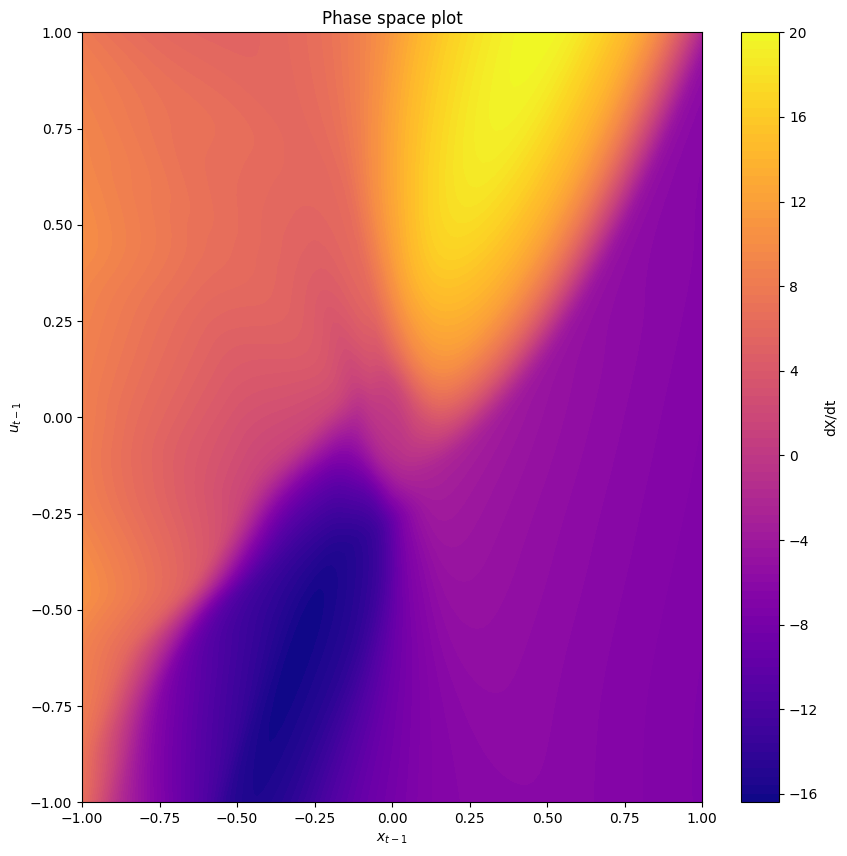

In [ ]:
x_in = np.linspace(-1, 1, 100)
u_in = np.linspace(-1, 1, 100)

X_in, U_in = np.meshgrid(x_in, u_in)

inputs = np.stack([X_in.flatten(), U_in.flatten()], axis=-1)
inputs = torch.from_numpy(inputs).float().to(DEVICE)
dX_dt = ode_net.network(inputs)

dX_dt = dX_dt.squeeze().unflatten(0, (100, 100)).detach().cpu().numpy()
print(dX_dt.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.contourf(X_in, U_in, dX_dt, cmap='plasma', levels=100)
fig.colorbar(cax, ax=ax, label='dX/dt')
ax.set_xlabel('$x_{t-1}$')
ax.set_ylabel('$u_{t-1}$')
ax.set_title('Phase space plot')
plt.show()

We can observe from the countour plot visualisation of the learned scalar field of the ode_net that the maximum velocity is produced when the force acts in the same direction as the displacement and perhaps suprisingly negative and positive velocities cannot be linearly seperated in the phase space. Finally, there is a clear stable equillibrium in the centre of the plot